# Time series clustering exercise

# Data

Download the census bureau business data for all years 1993-2014. You can investigate using the API (I have not done it with the census bureau). I did is as you see below

The data is on the github repo. Each file is the economic census for 1 year. 
Download it programmatically and move it to PUIdata

 Download the NYC zipcodes shapefile. One of many ways in which you can get the zipcodes shapefile for NYC
 https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip


## You can use zipfile module in python to unzip the files
it should be installed in your system, but if it is not you can get the code with wget from here
https://github.com/python/cpython/blob/2.7/Lib/zipfile.py
remembering to use the raw link
(or you can use the usual shell commands)

In [178]:
import pandas as pd
import zipfile 
try:
    from urllib import urlretrieve as urlretrieve
except ImportError:
    from urllib.request import urlretrieve as urlretrieve
import numpy as np
import os
import geopandas as gp
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.colors
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import scipy.cluster as scp
from matplotlib import pyplot

%matplotlib inline

In [2]:
os.environ["PUIDATA"] = "%s/PUIdata"%os.getenv("HOME")

In [52]:
urlretrieve("https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip", os.environ["PUIDATA"] + "/" + "nyc_zip.gz")

('/nfshome/ks5063/PUIdata/nyc_zip.gz',
 <http.client.HTTPMessage at 0x7f8877bdd748>)

In [54]:
!cd $PUIDATA;unzip nyc_zip.gz

Archive:  nyc_zip.gz
  inflating: ZIP_CODE_040114.shx     
  inflating: ZIP_CODE_040114.dbf     
  inflating: ZIP_CODE_040114.prj     
  inflating: ZIP_CODE_040114.sbn     
  inflating: ZIP_CODE_040114.sbx     
  inflating: ZIP_CODE_040114.shp     
  inflating: ZIP_CODE_040114.shp.xml  


In [90]:
nyczipsshp = gp.read_file(os.getenv("PUIDATA") + "/ZIP_CODE_040114.shp")
nyczips = nyczipsshp.ZIPCODE.values.astype(int)

In [4]:
all_files = ["zbp" + str(x)[-2:] + "totals.zip" for x in np.arange(1994,2015)]

In [24]:
for file in all_files:
    urlretrieve("https://github.com/fedhere/PUI2018_fb55/blob/master/HW12_fb55/" + file + "?raw=true", os.environ["PUIDATA"] + "/" + file)

In [91]:
df = pd.DataFrame(data = {"zip" : nyczips})

In [92]:
for i,file in enumerate(all_files):
    zf = zipfile.ZipFile(os.environ["PUIDATA"] + "/" + file)
    df2 = pd.read_csv(zf.open(file.replace('.zip','.txt')))
    for column in df2.columns:
        df2.rename(columns={column:column.lower()},inplace=True)
    #df2 = df2[["zip","name","empflag","emp","qp1","ap","est"]]
    df2 = df2[["zip","est"]]
    df2.rename(columns={"est":str(i)},inplace=True)
    df2 = df2[df2["zip"].isin(nyczips)]
    df = pd.merge(df,df2,how="left",on="zip")
    print(df.shape)

(263, 2)
(263, 3)
(263, 4)
(263, 5)
(263, 6)
(263, 7)
(263, 8)
(263, 9)
(263, 10)
(263, 11)
(263, 12)
(263, 13)
(263, 14)
(263, 15)
(263, 16)
(263, 17)
(263, 18)
(263, 19)
(263, 20)
(263, 21)
(263, 22)


In [93]:
df.set_index("zip",inplace=True)

# Data cleaning

In [94]:
df['mean'] = df.apply(lambda row: np.mean([row[str(x)] for x in range(21)]),axis=1)
df['std'] = df.apply(lambda row: np.std([row[str(x)] for x in range(21)]),axis=1)

In [95]:
for i in range(21):
    df[str(i)] = df.apply(lambda row: (row[str(i)] - row['mean']) / row['std'], axis=1) 

In [96]:
df.drop(['mean', 'std'],axis=1,inplace=True)

In [97]:
df.head()

0         1         2         3         4         5         6  \
zip                                                                           
11436 -1.328089 -1.380613 -1.223043 -1.328089 -1.328089 -0.960426 -0.592763   
11213 -1.469190 -1.337700 -1.215603 -0.999586 -0.811744 -0.839920 -0.802352   
11212 -1.104595 -1.240103 -1.141551 -0.833579 -0.932130 -0.661114 -0.919811   
11225 -1.253491 -1.188335 -1.177475 -0.938567 -0.873410 -0.949427 -0.862551   
11218 -1.511359 -1.370005 -1.209805 -1.087299 -0.884692 -0.738627 -0.682086   

              7         8         9    ...           11        12        13  \
zip                                    ...                                    
11436 -1.012950  0.090040 -0.120053    ...     0.300133  0.195087  0.405180   
11213 -0.652079 -0.154298  0.061719    ...    -0.060378  0.024151 -0.060378   
11212 -0.833579 -0.217634 -0.168358    ...    -0.094445 -0.303866 -0.094445   
11225 -0.808254 -0.189265 -0.091530    ...    -0.058951  0.027924  0.190816   
11218 -0.592562 -0.366397 -0.276873    ...     0.123628  0.118916  0.335658   

             14        15        16        17        18        19        20  
zip                                                                          
11436  0.720320  0.825366  1.140506  1.298076  0.982936  1.193030  1.718263  
11213  0.277737  0.550107  1.057280  1.047888  1.536276  1.808646  1.968311  
11212  0.090339  0.644689  1.285272  1.457737  1.556288  1.679477  1.938174  
11225  0.255973  0.505740  0.907540  1.092151  1.374497  1.917469  2.167237  
11218  0.429894  0.712600  0.792700  1.023578  1.409943  1.796309  2.027186  

[5 rows x 21 columns]

you may need to clean your data: for some NYC zip codes there may be no info
sanity check: you should have 20 (N_timestamps) datapoints per time series and about 250 zipcodes (Nzipcodes)


IMPORTANT: read the instructions below on pre-processing. Afte rthat:

mydata.shape should be (Nzipcodes, Ntimestamps)

mydata[i].std() shoould be 1 for all i in range(len(Nzipcodes))

mydata[i].mean() should be ~0 for all i in range(len(Nzipcodes))



In [98]:
df.shape

(263, 21)

In [99]:
[df.iloc[i,:].std() for i in range(len(nyczips))]

[1.0246950765959597,
 1.0246950765959599,
 1.0246950765959599,
 1.0246950765959599,
 1.0246950765959599,
 1.0246950765959599,
 1.0246950765959599,
 1.0246950765959599,
 1.0246950765959599,
 1.0246950765959599,
 1.0246950765959599,
 1.0246950765959599,
 1.0246950765959597,
 1.0246950765959599,
 1.0246950765959599,
 1.0246950765959599,
 1.0246950765959595,
 1.0246950765959599,
 1.0246950765959599,
 1.0246950765959599,
 1.0246950765959599,
 1.0246950765959597,
 1.0246950765959599,
 1.0246950765959597,
 1.0246950765959599,
 1.0246950765959599,
 1.0246950765959599,
 1.0246950765959595,
 1.0246950765959595,
 1.0246950765959597,
 1.0246950765959599,
 1.0246950765959599,
 1.0246950765959599,
 1.0246950765959599,
 1.0246950765959599,
 1.0246950765959599,
 1.0246950765959599,
 1.0246950765959599,
 1.0246950765959599,
 1.0246950765959599,
 1.0246950765959597,
 1.0246950765959599,
 1.0246950765959599,
 1.0246950765959599,
 1.0246950765959599,
 1.0246950765959599,
 1.0246950765959597,
 1.0246950765

In [100]:
[df.iloc[i,:].mean() for i in range(len(nyczips))]

[-3.0663302584885275e-16,
 -1.6917684184764289e-16,
 4.65236315081018e-16,
 -2.1147105230955362e-16,
 -2.32618157540509e-16,
 7.6129578831439301e-16,
 -1.0573552615477681e-16,
 -3.1720657846433045e-16,
 2.4319171015598669e-16,
 4.5466276246554026e-16,
 2.1147105230955362e-17,
 -1.522591576628786e-15,
 5.9211894646675012e-16,
 7.824428935453484e-16,
 2.5376526277146434e-16,
 -8.4588420923821446e-17,
 -1.163090787702545e-15,
 4.0179499938815189e-16,
 1.0573552615477681e-16,
 2.5376526277146434e-16,
 6.3441315692866089e-16,
 1.0573552615477681e-16,
 -5.6568506492805591e-16,
 -6.7670736739057157e-16,
 -4.5466276246554026e-16,
 5.9211894646675012e-16,
 -8.2473710400725917e-16,
 -1.163090787702545e-15,
 -1.163090787702545e-15,
 -2.0565559837104092e-15,
 -1.9032394707859825e-16,
 -2.9605947323337506e-16,
 -2.5376526277146434e-16,
 5.2867763077388404e-17,
 -1.7975039446312059e-16,
 2.9605947323337506e-16,
 2.4319171015598669e-16,
 -1.0573552615477681e-17,
 8.4588420923821446e-17,
 -5.286776307

## TASKS:
    
    1. get and prep your data.
    2. cluster the NUMBER OF ESTABLISHMENTS time series with K-means
    in **a few** clusters (as discussed there is no real good, sound way to 
    decide what a good number is here. try a few options, keeping in mind 
    a few is more than a couple, but i recommand you stay within the 
    single digit numbers)
    
    3. plot the cluster centers (if you used K means those are the means of 
    the clusters). you can plot for example the cluster centers overlayed on 
    each time series (using the alpha channel to control the opacity in the 
    plot may be helpful here).
    
    4. Use another clustering algorithm (of your choice)
    
    5. overlay your data on a NYC map: you can use shapefiles for the 
    zip codes and different colors for different clusters
    
    6. Compare the results of the 2 algorithms
    
    7. attempt an interpretation. this is dangerous ground: clustering is 
    an exploratory tool so you do not want to jump to conclusions because 
    you see some clusters! but seeing structure in your data can inform 
    your next moves as an investigator. 
    

Note on preprocessing: the preparation of these data should include the "standardization" of the time seris. 
*Always when you apply a moachine learning model you should standardize the data or whiten it.*
These operations may be complicated preprocessing operation, they can for example invoke PCA, and they are aimed at removing covariance in the feature space.

The simplest version of whitening *standardizes each feature*" from every column (feature) you subtract the mean and you divide it by the standard deviation.

But the time series preprocessing is different if you want to use each time stamp as feature: because you want to maintain the coherence of the data, i.e. you **do not want** to treat each feature as an independent feature! the pattenrs in the time series are what you are clustering on (time series goes up and down, creating a pattern) and those patterns would be lost by whitening.

*So when you cluster or otherwise use a time series in a model, using each timestamp as a feature, you want to standardize the observations, not the features.* 

**From each row of your table (observation, in this case each zipcode) subtract the mean and you divide the row by the standard deviation.**

In [101]:
#nyczipsshp.plot()
#nyczipsshp.drop_duplicates("ZIPCODE").plot()
#nyczipsshp
print("ZIPCODES:",
      len(np.unique(nyczipsshp.ZIPCODE)), "POLYGONS:",
      len(nyczipsshp.ZIPCODE),
      "the difference is due to island with same zip as parts of land,",
      "but disjoint shapes")
print("number of NYC zip codes:", len(nyczips))

ZIPCODES: 248 POLYGONS: 263 the difference is due to island with same zip as parts of land, but disjoint shapes
number of NYC zip codes: 263


In [102]:
# 20 years of data and 263 zipcodes
df.shape

(263, 21)

In [103]:
#cleaning all missing values
cleancsb = df.dropna()
cleancsb.shape

(243, 21)

In [104]:
#then the standardization will look like:
#vals = ((cleancsb.T - cleancsb.mean(1)) / cleancsb.std(1)).T
vals = cleancsb # data was already standardized in an earleir step

vals.mean(axis=1) should return 0 (or something very small) everywhere

vals.mean(axis=1).shape should be (260,)

vals.std(axis=1) should return 1 everywhere

vals.std(axis=1).shape

In [105]:
range_n_clusters = np.arange(2,10)

for n_clusters in range_n_clusters:
    km = KMeans(n_clusters=n_clusters, random_state=324)
    cluster_labels = km.fit_predict(vals)
    silhouette_avg = silhouette_score(vals, cluster_labels)
    print("For n_clusters = {},".format(n_clusters)+" the average silhouette_score is : {}".format(silhouette_avg))

For n_clusters = 2, the average silhouette_score is : 0.5721428017763125
For n_clusters = 3, the average silhouette_score is : 0.5414350202012774
For n_clusters = 4, the average silhouette_score is : 0.4956439006977136
For n_clusters = 5, the average silhouette_score is : 0.3335265626711548
For n_clusters = 6, the average silhouette_score is : 0.2829550395740287
For n_clusters = 7, the average silhouette_score is : 0.1667809489997153
For n_clusters = 8, the average silhouette_score is : 0.23875717815218825
For n_clusters = 9, the average silhouette_score is : 0.1539423920591001


In [106]:
nc = 3 # clustering with highest silhouette_score and number of clusters > 2

In [107]:
#cluster with kmeans
km = KMeans(n_clusters=nc, random_state=444).fit(vals)

In [108]:
#each observation in the km object has a label: 
#that is the cluster assigned to that observation
km.labels_.shape

(243,)

In [109]:
vals['pred'] = km.labels_

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [110]:
vals.reset_index(inplace=True)

In [111]:
vals['zip'] = vals['zip'].map(lambda x: str(x)) 

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [112]:
nyczipsshp = nyczipsshp.merge(vals, left_on="ZIPCODE", right_on="zip", how="left") 

In [113]:
nyczipsshp.drop([str(x) for x in range(21)], axis=1, inplace=True)

In [114]:
nyczipsshp.fillna(3,inplace=True)

### The map of the clusters may look something like this

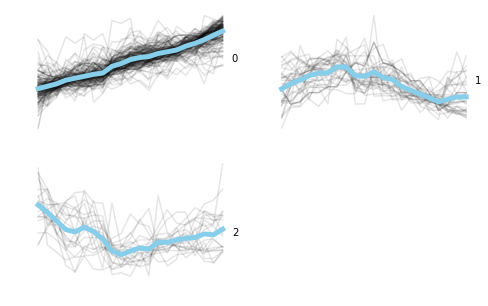

In [177]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(8,5))

for i in range(4):
    cluster_i = vals[vals["pred"]==i]
    for j in range(cluster_i.shape[0]):
        axes[int(i/2), int(i%2)].plot(range(21),cluster_i.iloc[j,1:-1],color="black",alpha=0.1)
    axes[int(i/2), int(i%2)].plot(range(21),np.mean(cluster_i.iloc[:,1:-1],axis=0),color="skyblue",linewidth=5)
    axes[int(i/2), int(i%2)].set_axis_off()
    if i < 3:
        axes[int(i/2), int(i%2)].text(21, 0, int(i))

### Figure 1:
The business pattern time series are plotted for each cluster. The cluster center is represented by the thick blue line.

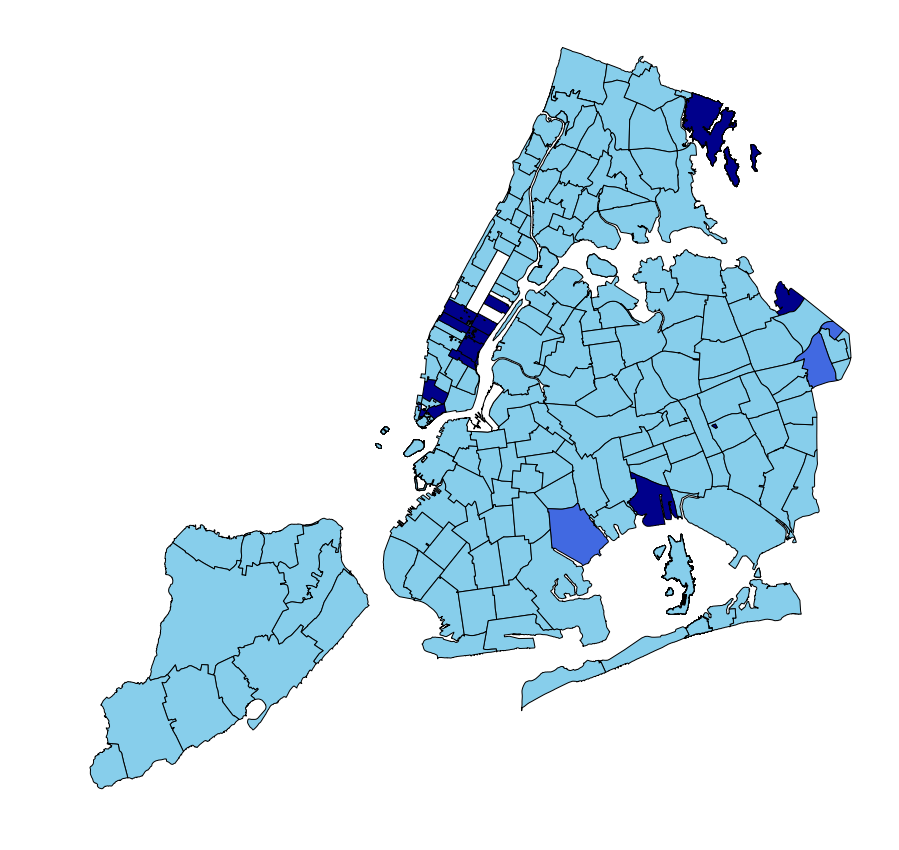

In [202]:
colors = ["skyblue","darkblue","royalblue","white"]
cmap = matplotlib.colors.ListedColormap(colors)

f,ax = plt.subplots(figsize=(15,15))
nyczipsshp.plot(column="pred",cmap=cmap,ax=ax,edgecolor="black")
ax.set_axis_off()

### Figure 2: 
chloropleth of  cluster centers for 3 k-means clusters of business patterns (number of businesses) at the zipcode level for NYC zipcodes: each color indicates a cluster. Missing values are reprented in white.

### or maybe like this, depending on which algorithm you use, and how you proceed to preprocess your data and how you cluster it. There is no one correct answer, but general trends should be retrieved.

# If you want to use agglomerative clustering

In [180]:
vals.set_index("zip",inplace=True)
vals.drop(["pred"],axis=1,inplace=True)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [182]:
agc = AgglomerativeClustering(n_clusters=nc, linkage='average').fit(vals)
vals.reset_index(inplace=True)
vals["pred2"] = agc.labels_
centroidsag = np.zeros((nc, vals.shape[1]))

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [184]:
nyczipsshp = nyczipsshp.merge(vals,on="zip", how="left") 

In [185]:
nyczipsshp.drop([str(x) for x in range(21)], axis=1, inplace=True)

In [186]:
nyczipsshp.fillna(3,inplace=True)

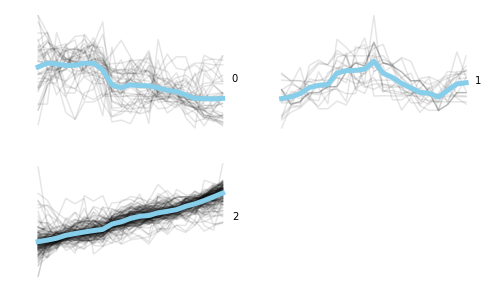

In [189]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(8,5))

for i in range(4):
    cluster_i = vals[vals["pred2"]==i]
    for j in range(cluster_i.shape[0]):
        axes[int(i/2), int(i%2)].plot(range(21),cluster_i.iloc[j,1:-1],color="black",alpha=0.1)
    axes[int(i/2), int(i%2)].plot(range(21),np.mean(cluster_i.iloc[:,1:-1],axis=0),color="skyblue",linewidth=5)
    axes[int(i/2), int(i%2)].set_axis_off()
    if i < 3:
        axes[int(i/2), int(i%2)].text(21, 0, int(i))

### Figure 3:
The business pattern time series are plotted for each cluster. The cluster center is represented by the thick blue line.

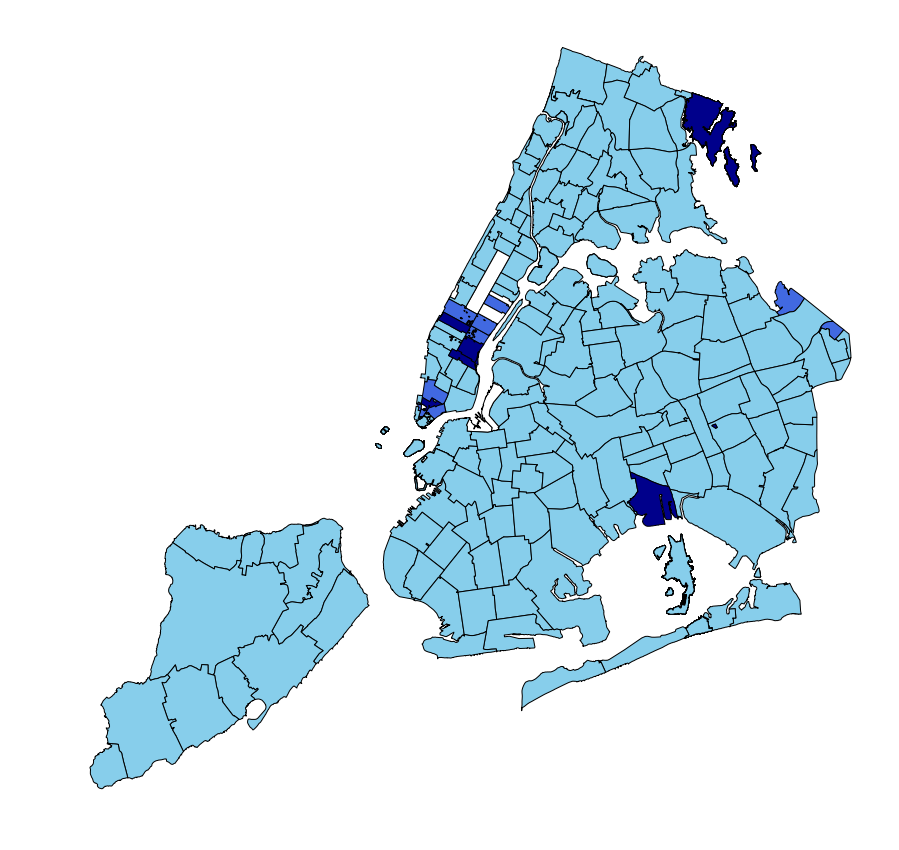

In [192]:
colors = ["royalblue","darkblue","skyblue","white"]
cmap = matplotlib.colors.ListedColormap(colors)

f,ax = plt.subplots(figsize=(15,15))
nyczipsshp.plot(column="pred2",cmap=cmap,ax=ax,edgecolor="black")
ax.set_axis_off()

### Figure 4:
chloropleth of  cluster centers for 3 k-means clusters of business patterns (number of businesses) at the zipcode level for NYC zipcodes: each color indicates a cluster. Missing values are reprented in white.

# Compare the results of the two alogrithms

In [201]:
print("Cluster distribution for KMeans clustering: {}, {}, {}".format(nyczipsshp[nyczipsshp["pred"]==0].shape[0],nyczipsshp[nyczipsshp["pred"]==1].shape[0],nyczipsshp[nyczipsshp["pred"]==2].shape[0]))

Cluster distribution for KMeans clustering: 337, 60, 20


In [200]:
print("Cluster distribution for Agglomerative clustering: {}, {}, {}".format(nyczipsshp[nyczipsshp["pred2"]==2].shape[0],nyczipsshp[nyczipsshp["pred2"]==1].shape[0],nyczipsshp[nyczipsshp["pred2"]==0].shape[0]))

Cluster distribution for Agglomerative clustering: 338, 42, 37


<strong>
    <ul>
        <li>The distribution of clusters is somewhat similar for both the algorithms.</li>
        <li>There are three similar trends noticed in both the algorithms:</li>
            <ol>
                <li>Cluster 0 in Kmeans and Cluster 2 in Agglomeratuve clustering represent linearly increasing trend.</li>
                <li>Cluster 2 in Kmeans and Cluster 0 in Agglomeratuve clustering represent overall decrease due a sharp decrease in the middle of the series.</li>
                <li>Cluster 1 in Kmeans and Cluster 1 in Agglomeratuve clustering represent a curve which increases in first half of the series and decreases in second half of the series.</li>
            </ol>
    </ul>
</strong>

# Attempt at interpretation

<strong>
<ul>
    <li>The difference in distribution between the alogorithms is between the two following trends:<li>
    <ol>
        <li>Overall decrease due a sharp decrease in the middle of the series.</li>
        <li>Curve which increases in first half of the series and decreases in second half of the series.</li>
    </ol>
    <br>
    <li>A possible reason is that both the series are similar in the sense that both have a sharp decrease near the middle of the series.</li>
    <li>A possible conclusion might be to model the time series using two clusters instead of three since two of the three resulting series have relatively similar trends.</li>
    <li>This might also be confirmed by the analysis that two clusters had a higher silhouette score than three clusters.</li>
</ul>  
</strong>